Random Forest
=======

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

from scipy import interp

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(200000)

In [3]:
data = data.reset_index()
data = data.drop("index", axis = 1)

In [4]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status,zip_code
0,NY,35000.0,Individual,1630.0,197.0,96.8,0.0,0.0,Cash,9.05,...,D4,0.0,36 months,86.0,8400.0,8149.0,6200.0,0.0,Verified,100xx
1,FL,30000.0,Individual,618.0,5360.0,35.4,0.0,0.0,Cash,8.79,...,C2,0.0,36 months,0.0,19394.0,5560.0,8300.0,2594.0,Source Verified,327xx
2,GA,56000.0,Individual,23298.0,1665.0,86.1,0.0,0.0,Cash,16.16,...,C4,0.0,36 months,0.0,178239.0,32535.0,12000.0,26545.0,Source Verified,310xx
3,NV,33420.0,Individual,130.0,640.0,28.9,1.0,0.0,Cash,0.90,...,E2,0.0,36 months,0.0,1200.0,260.0,900.0,0.0,Source Verified,895xx
4,WA,40000.0,Individual,1207.0,2450.0,66.0,0.0,0.0,Cash,13.71,...,D2,0.0,36 months,0.0,22334.0,12071.0,7200.0,13834.0,Not Verified,986xx


In [5]:
data.shape

(200000, 50)

Data balance:

In [6]:
data['loan_status'].value_counts()

0.0    158708
1.0     41292
Name: loan_status, dtype: int64

#### Pre-processing:

Categorical_variables

In [7]:
categorical_variables = data.select_dtypes(include="object").columns

In [8]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [9]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [10]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status,zip_code
0,0.227974,35000.0,0.20662,1630.0,197.0,96.8,0.0,0.0,0.206054,9.05,...,0.327042,0.0,0.165595,86.0,8400.0,8149.0,6200.0,0.0,0.242779,0.195181
1,0.223998,30000.0,0.20662,618.0,5360.0,35.4,0.0,0.0,0.206054,8.79,...,0.214335,0.0,0.165595,0.0,19394.0,5560.0,8300.0,2594.0,0.221280,0.212034
2,0.186933,56000.0,0.20662,23298.0,1665.0,86.1,0.0,0.0,0.206054,16.16,...,0.258358,0.0,0.165595,0.0,178239.0,32535.0,12000.0,26545.0,0.221280,0.182143
3,0.241379,33420.0,0.20662,130.0,640.0,28.9,1.0,0.0,0.206054,0.90,...,0.375446,0.0,0.165595,0.0,1200.0,260.0,900.0,0.0,0.221280,0.173759
4,0.169245,40000.0,0.20662,1207.0,2450.0,66.0,0.0,0.0,0.206054,13.71,...,0.301009,0.0,0.165595,0.0,22334.0,12071.0,7200.0,13834.0,0.149995,0.133803


In [11]:
data.shape

(200000, 50)

Target:

In [27]:
X = data.loc[:, data.columns!='loan_status']

In [28]:
y = data['loan_status']

Random Forest
=======
__________

In [14]:
random_forest = RandomForestClassifier(n_estimators = 50)

Parameters to randomize:

In [15]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Randomize search with Cross Validation:

In [16]:
random_search = RandomizedSearchCV(random_forest, n_iter=50, param_distributions=param_dist,
                                   cv=3, scoring="roc_auc", n_jobs=4, verbose=1)

In [17]:
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 29.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92a25730b8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92a25731d0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92a25734a8>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tru

__Cross Validation Results:__

In [18]:
pd.set_option('display.max_columns', None)
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,77.124673,1.462670,0.920044,1.000000,False,entropy,None,6,4,7,"{'bootstrap': False, 'criterion': 'entropy', '...",15,0.919352,1.000000,0.921234,1.000000,0.919545,1.000000,0.919445,0.026821,0.000845,1.618501e-10
1,19.908408,1.394291,0.889855,0.976640,True,entropy,None,2,9,3,"{'bootstrap': True, 'criterion': 'entropy', 'm...",25,0.890231,0.976627,0.891491,0.976209,0.887844,0.977085,1.559166,0.137049,0.001512,3.575493e-04
2,25.369345,2.053210,0.862868,1.000000,False,entropy,None,1,2,5,"{'bootstrap': False, 'criterion': 'entropy', '...",34,0.861651,1.000000,0.864375,1.000000,0.862577,1.000000,0.513307,0.120742,0.001131,1.132952e-09
3,11.990057,0.398573,0.839795,0.841246,False,gini,3,6,5,10,"{'bootstrap': False, 'criterion': 'gini', 'max...",44,0.841868,0.844040,0.846141,0.844366,0.831375,0.835332,0.415673,0.004463,0.006204,4.184285e-03
4,19.275943,0.430548,0.863926,0.864882,False,entropy,3,8,2,5,"{'bootstrap': False, 'criterion': 'entropy', '...",33,0.864155,0.867113,0.863001,0.860126,0.864623,0.867407,1.061825,0.029673,0.000682,3.365302e-03
5,11.191954,0.483315,0.841858,0.843247,False,gini,3,5,3,8,"{'bootstrap': False, 'criterion': 'gini', 'max...",43,0.844109,0.846509,0.840428,0.838593,0.841036,0.844639,1.244725,0.102889,0.001611,3.377930e-03
6,59.263095,1.723348,0.911611,1.000000,False,gini,None,5,3,2,"{'bootstrap': False, 'criterion': 'gini', 'max...",21,0.910075,1.000000,0.913168,1.000000,0.911590,1.000000,0.860462,0.105402,0.001263,5.676885e-09
7,55.692627,1.547182,0.915711,1.000000,True,gini,None,8,1,2,"{'bootstrap': True, 'criterion': 'gini', 'max_...",20,0.915778,1.000000,0.916425,1.000000,0.914931,1.000000,1.371832,0.047984,0.000612,1.962328e-09
8,105.479703,1.716327,0.922665,0.999943,False,entropy,None,8,7,7,"{'bootstrap': False, 'criterion': 'entropy', '...",7,0.920817,0.999949,0.924484,0.999937,0.922694,0.999945,7.691630,0.332582,0.001497,5.087619e-06
9,25.947978,0.478779,0.864564,0.865176,False,entropy,3,10,3,8,"{'bootstrap': False, 'criterion': 'entropy', '...",32,0.861862,0.864921,0.870641,0.867656,0.861190,0.862951,4.826859,0.063208,0.004306,1.929270e-03


In [19]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 9,
 'min_samples_split': 3}

In [20]:
random_search.best_score_

0.9235566639413747

Feature importance:

Text(0.5,1,'Feature importance')

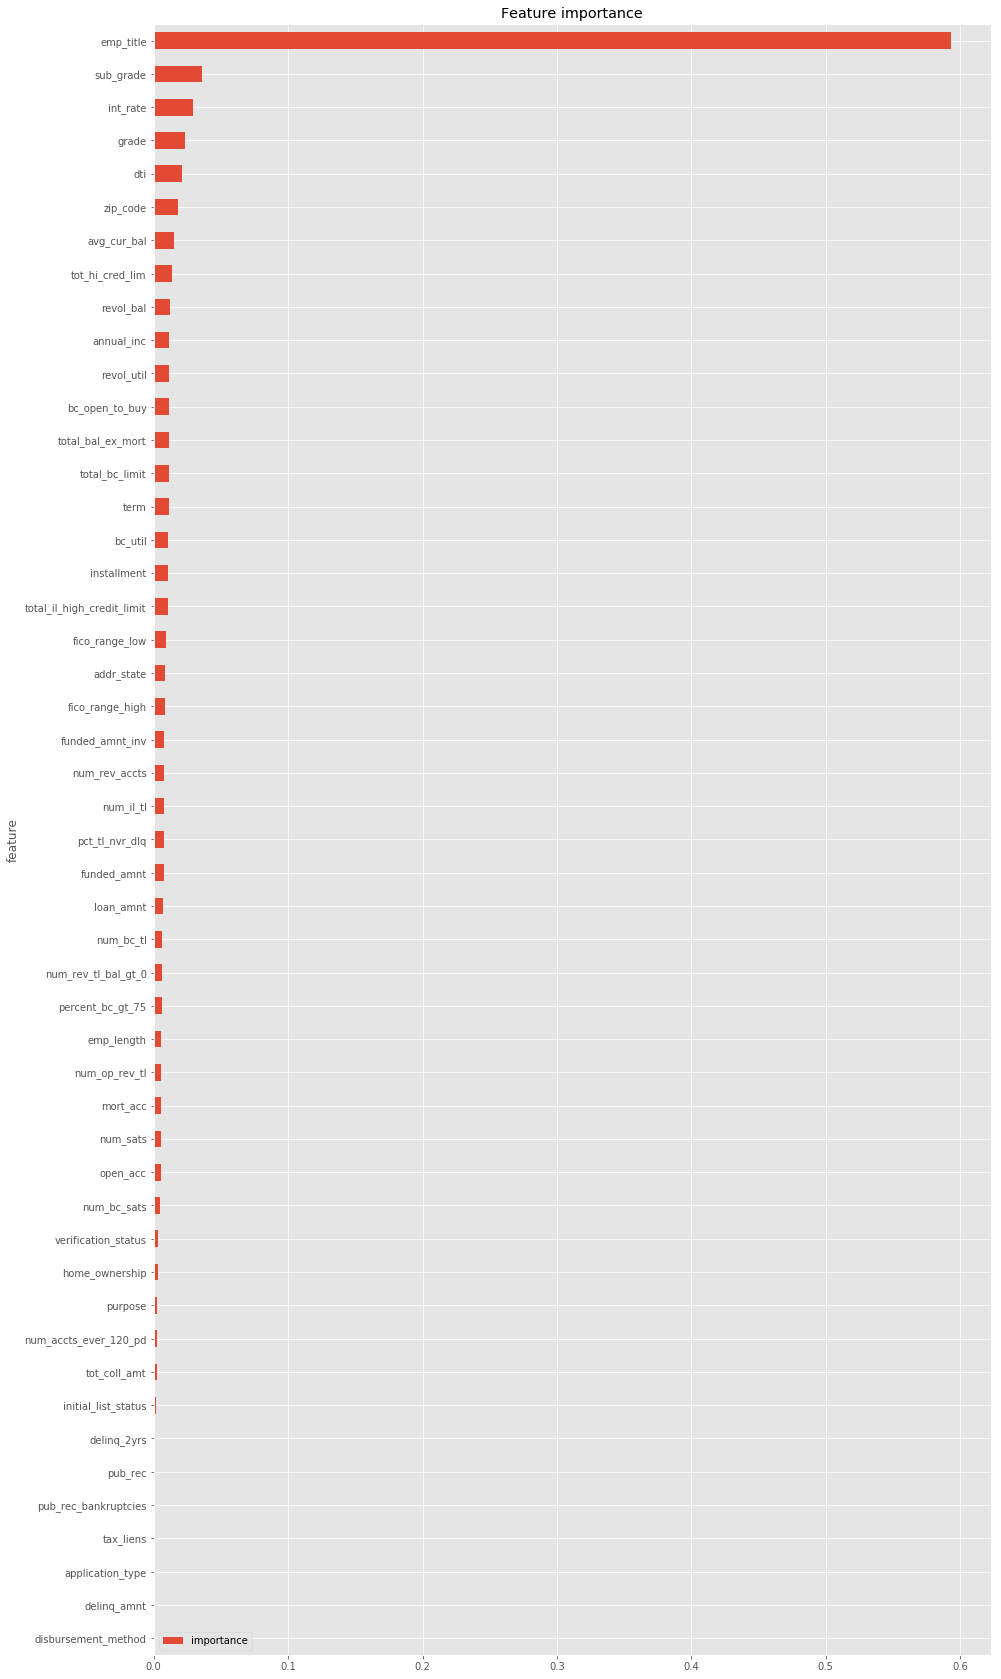

In [21]:
features = pd.DataFrame({'feature':X.columns,
                         'importance':random_search.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,30)).set_title('Feature importance')

As we already concluded in the feature engineering part of the project, the `emp_title` has a huge importance in the model although we didn't think that this variable had such a big impact in the model. `zip_code` is the second most important feature in the model. 

It's important to notice that there were 56 different types of employee title and 137 kind of zip codes which have been processed in just two variables (instead of 193 features if we would process the categorical data as One Hot Enconding) which it makes the model much less computationally heavy and more accuratly in terms of its performance.

Model Evaluation
==========
_________________

Run classifier with cross-validation and plot __ROC curves__:

In [34]:
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=None,
                                    max_features=10, min_samples_leaf=9, min_samples_split=3,
                                    n_estimators=200)

In [29]:
# dataframes to numpy arrays
X = X.values
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

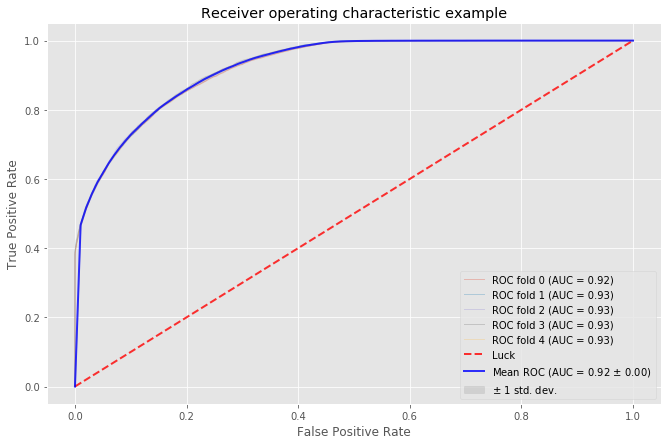

In [35]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(11,7))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [36]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [37]:
metrics

,accuracy,auc,precision,recall
0,0.883653,0.923697,0.858849,0.522339
1,0.885303,0.925904,0.861960,0.529241
2,0.884300,0.926113,0.869203,0.517438
3,0.884172,0.926536,0.864762,0.520344
4,0.884597,0.925046,0.871178,0.517559


In [38]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.884405
auc          0.925459
precision    0.865190
recall       0.521384
dtype: float64